# The Zillow Price Challenge

The Zillow challenge is about predicting the error in zestimate prices of real estate.
In This notebook I will go in the following order :
1. Importing and exploring the data
2. Minimal Cleaning of data
3. Baseline model
4. Further cleaning and carefully imputing the data
5. Creating new features and testing its usefulness
6. Exploring different models on the final data

[ I will go in the above flow and answer the required questions of the HW through the course of the notebook. ]

## 1. Importing and Exploring the data

Here we will start with importing the standard libraries required for the notebook.
Next we will load the Training and properties data and prints its shape.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import gc

%matplotlib inline


In [2]:
prop_data = pd.read_csv("properties_2016.csv")
all_columns = prop_data.columns.values
print prop_data.shape
prop_data.head()

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [3]:
train_df = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
train_data = train_df
print train_data.shape
print train_data.head()

(90275, 3)
   parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02


### Plotting the logerror

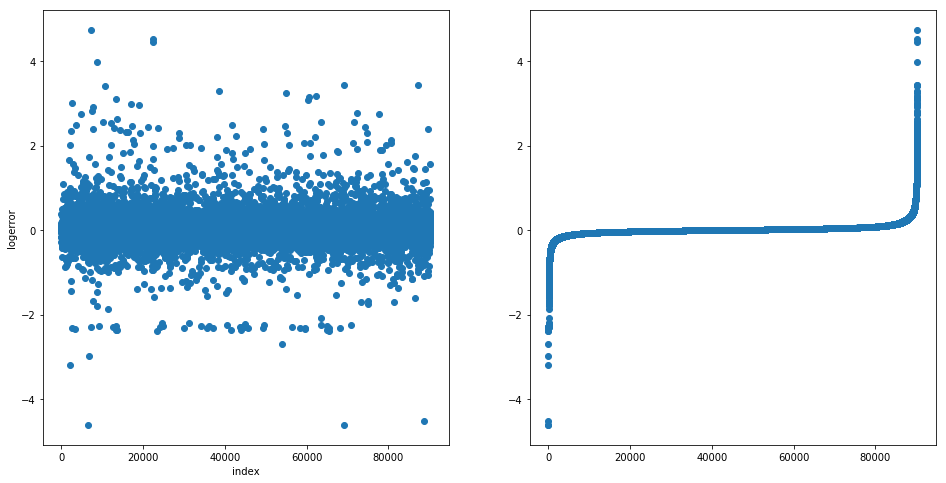

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


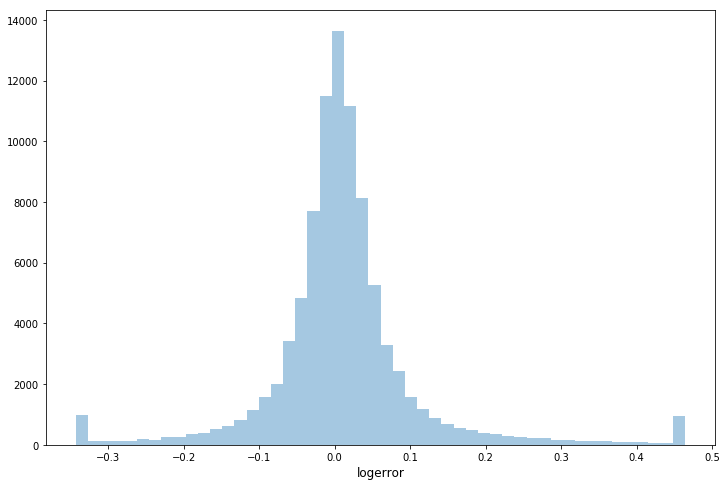

In [4]:
logerror = train_data["logerror"]
hist, bins = np.histogram(logerror, bins=50)
center = (bins[:-1] + bins[1:]) / 2
width = 0.7 * (bins[1]-bins[0])
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.xlabel("index")
plt.ylabel("logerror")
plt.scatter(range(train_data.shape[0]), logerror)
plt.subplot(122)
plt.scatter(range(train_data.shape[0]), np.sort(logerror))
plt.show()
# plt.subplot(133)
ulimit = np.percentile(train_data.logerror.values, 99)
llimit = np.percentile(train_data.logerror.values, 1)
train_data['logerror'].loc[train_data['logerror']>ulimit] = ulimit
train_data['logerror'].loc[train_data['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sb.distplot(train_data.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

del logerror
del hist
del bins

From the above histogram we can observe that the logerror follows a normal distribution.
There are a few outliers at the end, however most of the data resides with 1st standard distribution around the mean

### Plotting the missing value count

Here we will analyse the amount of missing values per column in the properties data.

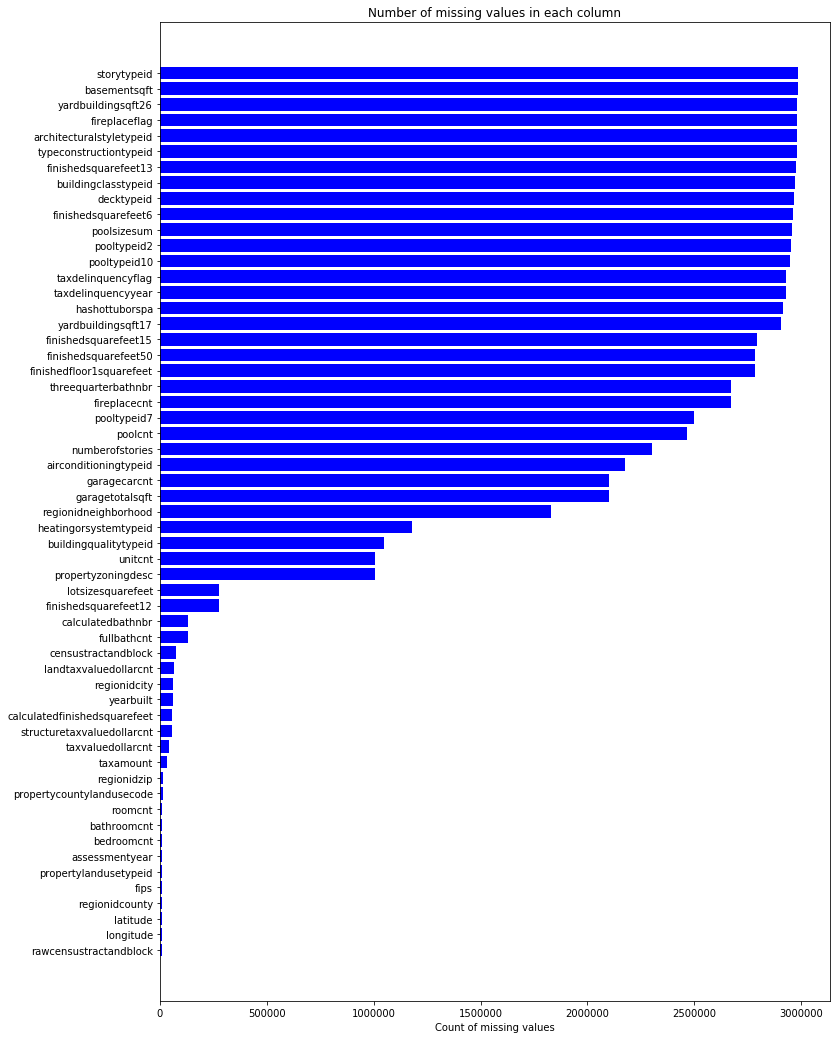

In [5]:
missing_val = prop_data.isnull().sum().reset_index()
missing_val.columns = ['column_name', 'missing_count']
missing_val = missing_val.loc[missing_val['missing_count']>0]
missing_val = missing_val.sort_values(by='missing_count')

ind = np.arange(missing_val.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_val.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_val.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

del ind

## 2. Performing minimal cleaning

In this step we will remove those columns which have more than 99.5% missing values.

In [6]:
missing_val['missing_ratio'] = missing_val["missing_count"]/prop_data.shape[0]
missing_val = missing_val.loc[missing_val["missing_ratio"]>0.995]
missing_val


,column_name,missing_count,missing_ratio
6,buildingclasstypeid,2972588,0.995769
13,finishedsquarefeet13,2977545,0.997430
43,typeconstructiontypeid,2978470,0.997740
2,architecturalstyletypeid,2979156,0.997970
49,fireplaceflag,2980054,0.998270
46,yardbuildingsqft26,2982570,0.999113
3,basementsqft,2983589,0.999455
41,storytypeid,2983593,0.999456


In [7]:
prop_data.drop(missing_val.column_name.values, axis=1, inplace=True)


We can also try to find the missing value count for the rows. However, we cannot delete rows because each parcelid in the properties data is required in the final submission to the competition.


In [8]:
missing_val_rows = prop_data.isnull().sum(axis=1).reset_index()
missing_val_rows.columns = ["row_index", "null_count"]
missing_val_rows["missing_ratio"] = missing_val_rows["null_count"]/prop_data.shape[1]
missing_val_rows["missing_ratio"]


0          0.66
1          0.64
2          0.54
3          0.48
4          0.50
5          0.48
6          0.60
7          0.52
8          0.64
9          0.50
10         0.50
11         0.66
12         0.64
13         0.64
14         0.64
15         0.64
16         0.62
17         0.52
18         0.52
19         0.42
20         0.48
21         0.50
22         0.46
23         0.46
24         0.48
25         0.62
26         0.46
27         0.48
28         0.40
29         0.42
           ... 
2985187    0.98
2985188    0.98
2985189    0.98
2985190    0.98
2985191    0.98
2985192    0.98
2985193    0.98
2985194    0.98
2985195    0.98
2985196    0.98
2985197    0.98
2985198    0.98
2985199    0.98
2985200    0.98
2985201    0.98
2985202    0.98
2985203    0.98
2985204    0.98
2985205    0.98
2985206    0.98
2985207    0.98
2985208    0.98
2985209    0.98
2985210    0.98
2985211    0.98
2985212    0.98
2985213    0.98
2985214    0.98
2985215    0.98
2985216    0.98
Name: missing_ratio, Len

In [9]:
del missing_val
del missing_val_rows
gc.collect()

prop_data.shape

(2985217, 50)

### Plotting the latitude and longitude values

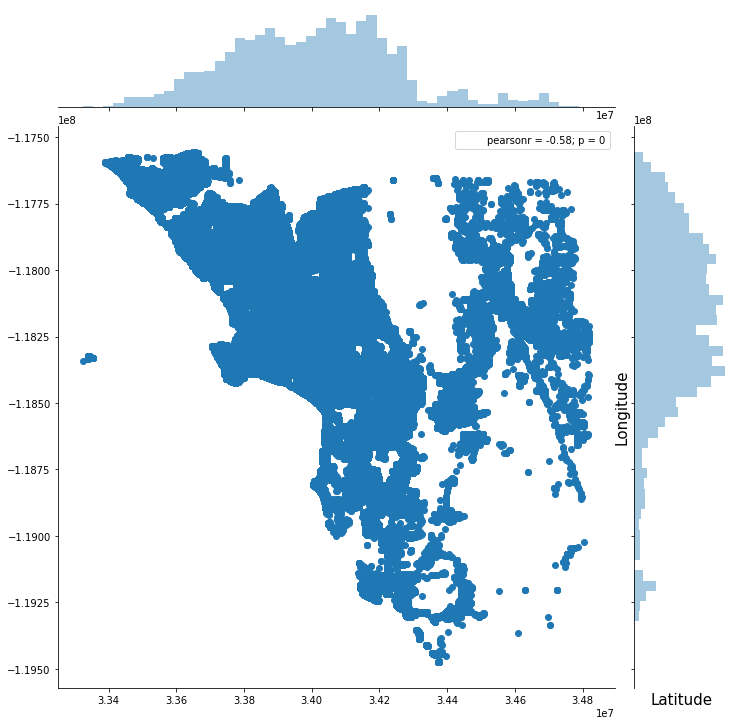

In [10]:
plt.figure(figsize=(12,12))
sb.jointplot(x=prop_data.latitude.values, y=prop_data.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=15)
plt.xlabel('Latitude', fontsize=15)
plt.show()

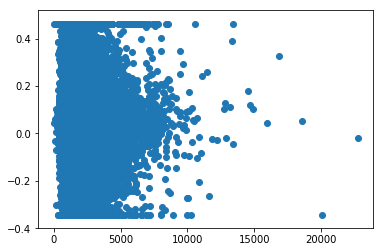

In [11]:
train_data_new = train_data.merge(prop_data, on='parcelid', how='left')
plt.scatter(train_data_new.calculatedfinishedsquarefeet, train_data_new.logerror)
plt.show()

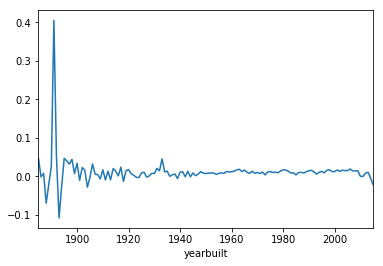

In [12]:
train_data_new.groupby("yearbuilt")["logerror"].mean().plot()

In [13]:
# plt.figure(figsize=(12,12))
# scaled_log_error = (10*(train_data.logerror.values - train_data.logerror.min())/train_data.logerror.ptp()).round()
# plt.scatter(prop_data.latitude.values, prop_data.longitude.values, c=scaled_log_error, s=500, cmap='gray')
# plt.ylabel('Longitude', fontsize=12)
# plt.xlabel('Latitude', fontsize=12)
# plt.show()

## 3. Baseline Model

This is a Linear Regression model which is used on the minimally cleaned data.

Here we remove the following **non-float** columns that contain string values:
1. propertycountylandusecode
2. taxdelinquencyflag
3. hashottuborspa
4. propertyzoningdesc

We also remove the categorical columns like:
1. airconditioningtypeid
2. propertylandusetypeid
3. heatingorsystemtypeid

Here We are imputing the missing values with -1 in each column.

In [15]:
train_data = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
train_data = train_data.merge(prop_data, on='parcelid', how='left')

sample = pd.read_csv("./sample_submission.csv")
sample['parcelid'] = sample['ParcelId']
test_months = [k for k in sample.columns.values if k not in ["parcelid"]]

for c in train_data.columns:
    print c, train_data[c].dtype


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

train_data.fillna(-1, inplace = True)

non_float_cols = ["propertycountylandusecode", "taxdelinquencyflag", "hashottuborspa"]
cat_cols = ["airconditioningtypeid", "heatingorsystemtypeid", "propertylandusetypeid"]


X_train = train_data.drop(["parcelid", "logerror", "transactiondate", "propertyzoningdesc"]+non_float_cols, axis=1)
y_train = train_data["logerror"].values

X_test = sample.merge(prop_data, on='parcelid', how='left')
print X_test.shape

X_test = X_test[X_train.columns]
X_test.fillna(-1, inplace=True)
for c in X_test.dtypes[X_test.dtypes == object].index.values:
    X_test[c] = (X_test[c] == True)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

    
from datetime import datetime

for date in test_months:
    sample[date] = y_pred

sample["ParcelId"] = sample["parcelid"]
print sample.head()
sample.drop(["parcelid"], axis=1, inplace=True)

print( "\nWriting results to disk ..." )
sample.to_csv('baseline_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\nFinished ...")

print("\nWorking on local data")
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


# The mean squared error
print("Mean squared error: % f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))


parcelid int64
logerror float64
transactiondate datetime64[ns]
airconditioningtypeid float64
bathroomcnt float64
bedroomcnt float64
buildingqualitytypeid float64
calculatedbathnbr float64
decktypeid float64
finishedfloor1squarefeet float64
calculatedfinishedsquarefeet float64
finishedsquarefeet12 float64
finishedsquarefeet15 float64
finishedsquarefeet50 float64
finishedsquarefeet6 float64
fips float64
fireplacecnt float64
fullbathcnt float64
garagecarcnt float64
garagetotalsqft float64
hashottuborspa object
heatingorsystemtypeid float64
latitude float64
longitude float64
lotsizesquarefeet float64
poolcnt float64
poolsizesum float64
pooltypeid10 float64
pooltypeid2 float64
pooltypeid7 float64
propertycountylandusecode object
propertylandusetypeid float64
propertyzoningdesc object
rawcensustractandblock float64
regionidcity float64
regionidcounty float64
regionidneighborhood float64
regionidzip float64
roomcnt float64
threequarterbathnbr float64
unitcnt float64
yardbuildingsqft17 float64

## 4. Further cleaning and carefully imputing the data

Initially we remove the columns with more than 80% data missing.

In [16]:
missing_val = prop_data.isnull().sum().reset_index()
missing_val.columns = ['column_name', 'missing_count']
missing_val = missing_val.loc[missing_val['missing_count']>0]
missing_val = missing_val.sort_values(by='missing_count')
missing_val['missing_ratio'] = missing_val["missing_count"]/prop_data.shape[0]
missing_val = missing_val.loc[missing_val["missing_ratio"]>0.80]
missing_val

,column_name,missing_count,missing_ratio
23,poolcnt,2467683,0.826634
27,pooltypeid7,2499758,0.837379
14,fireplacecnt,2672580,0.895272
37,threequarterbathnbr,2673586,0.895609
7,finishedfloor1squarefeet,2782500,0.932093
11,finishedsquarefeet50,2782500,0.932093
10,finishedsquarefeet15,2794419,0.936086
39,yardbuildingsqft17,2904862,0.973082
18,hashottuborspa,2916203,0.976881
48,taxdelinquencyyear,2928753,0.981085


In [17]:
prop_data.drop(missing_val.column_name.values, axis=1, inplace=True)
prop_data.head()

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,...,0.0,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN
1,10759547,NaN,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,...,0.0,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN
2,10843547,NaN,0.0,0.0,NaN,NaN,73026.0,NaN,6037.0,NaN,...,0.0,2.0,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN
3,10859147,NaN,0.0,0.0,7.0,NaN,5068.0,NaN,6037.0,NaN,...,0.0,NaN,1948.0,1.0,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN
4,10879947,NaN,0.0,0.0,NaN,NaN,1776.0,NaN,6037.0,NaN,...,0.0,1.0,1947.0,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN


In [18]:
missing_val_rows = prop_data.isnull().sum(axis=1).reset_index()
missing_val_rows.columns = ["row_index", "null_count"]
missing_val_rows["missing_ratio"] = missing_val_rows["null_count"]/prop_data.shape[1]
missing_val_rows["missing_ratio"]

0          0.500000
1          0.470588
2          0.352941
3          0.264706
4          0.294118
5          0.264706
6          0.411765
7          0.323529
8          0.470588
9          0.294118
10         0.294118
11         0.500000
12         0.470588
13         0.470588
14         0.470588
15         0.470588
16         0.441176
17         0.323529
18         0.294118
19         0.147059
20         0.264706
21         0.294118
22         0.294118
23         0.235294
24         0.264706
25         0.441176
26         0.235294
27         0.264706
28         0.117647
29         0.147059
             ...   
2985187    0.970588
2985188    0.970588
2985189    0.970588
2985190    0.970588
2985191    0.970588
2985192    0.970588
2985193    0.970588
2985194    0.970588
2985195    0.970588
2985196    0.970588
2985197    0.970588
2985198    0.970588
2985199    0.970588
2985200    0.970588
2985201    0.970588
2985202    0.970588
2985203    0.970588
2985204    0.970588
2985205    0.970588


It is a good practice to delete the variables that won't be used further. 
This saves memory and prevents the kernel from crashing in case the memory is full.

It is also advisable to save the data to external files at some checkpoints through the pipeline. 

In [19]:
print "Saving this modified data to prop_data_mod.csv"

prop_data_new = prop_data
prop_data_new.fillna(-1).to_csv("./prop_data_mod.csv")
prop_data.head()

del sample
del missing_val
del missing_val_rows
del prop_data_new
del train_data
gc.collect()


Saving this modified data to prop_data_mod.csv


519

In [20]:
dtype_df = prop_data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
# dtype_df.groupby("Column Type").aggregate("count").reset_index()


,Count,Column Type
0,parcelid,int64
1,airconditioningtypeid,float64
2,bathroomcnt,float64
3,bedroomcnt,float64
4,buildingqualitytypeid,float64
5,calculatedbathnbr,float64
6,calculatedfinishedsquarefeet,float64
7,finishedsquarefeet12,float64
8,fips,float64
9,fullbathcnt,float64


### Checking the value count for each feature

In [21]:
for column in prop_data:
    print column, "\n",prop_data[column].value_counts(dropna=False), "\n\n\n********"

parcelid 
12584959    1
12755709    1
12751611    1
12753658    1
12747513    1
12749560    1
12776183    1
12778230    1
12772085    1
12774132    1
12767987    1
12770034    1
12763889    1
12729070    1
12722925    1
12724972    1
12718827    1
12720874    1
12714729    1
12743399    1
12745446    1
12757756    1
12761854    1
12741348    1
12759807    1
14016022    1
12820200    1
12427380    1
17066269    1
11446598    1
           ..
10861026    1
10854881    1
10856928    1
10768863    1
10770910    1
10764765    1
10766812    1
10824176    1
10828274    1
10826227    1
10834431    1
12253706    1
12247561    1
12227079    1
12222981    1
12225028    1
12237314    1
12231169    1
12233216    1
10836478    1
10815988    1
10830333    1
10832380    1
10842619    1
10844666    1
10838521    1
10840568    1
10820086    1
10813941    1
12582912    1
Name: parcelid, Length: 2985217, dtype: int64 


********
airconditioningtypeid 
NaN      2173698
 1.0      742364
 13.0      58457
 5.0

NaN            11437
 33984600.0      862
 33708500.0      760
 34056700.0      740
 34171800.0      611
 33766300.0      568
 33785200.0      559
 34048000.0      555
 34169800.0      553
 34058000.0      541
 33665651.0      524
 33856782.0      513
 34056400.0      510
 33771600.0      504
 34150700.0      497
 34136300.0      484
 33699800.0      463
 34410700.0      455
 33770500.0      435
 33869800.0      429
 33958200.0      428
 33867865.0      422
 33825300.0      422
 33623100.0      421
 33825000.0      419
 34063400.0      416
 34041500.0      402
 33697400.0      401
 34150100.0      396
 33771300.0      395
               ...  
 34617640.0        1
 34450526.0        1
 34184778.0        1
 33755881.0        1
 33660013.0        1
 33659394.0        1
 34163307.0        1
 34063374.0        1
 33673100.0        1
 33720520.0        1
 34169801.0        1
 34661556.0        1
 33635653.0        1
 33467813.0        1
 33704082.0        1
 34661754.0        1
 34002774.0  

 3101.0    2009362
 1286.0     741565
 2061.0     222853
NaN          11437
Name: regionidcounty, dtype: int64 


********
regionidneighborhood 
NaN          1828815
 118208.0      32267
 268496.0      23186
 48570.0       21186
 27080.0       18891
 37739.0       18645
 54300.0       17749
 33183.0       16953
 34213.0       16607
 51906.0       15660
 41131.0       15451
 48200.0       14860
 31817.0       14690
 276476.0      14566
 113455.0      14353
 46736.0       14349
 40548.0       13320
 268588.0      12894
 274514.0      12686
 274049.0      12600
 41466.0       11180
 40215.0       10837
 6952.0        10795
 27987.0       10616
 47950.0       10446
 47880.0       10445
 113910.0      10238
 118920.0      10226
 118872.0      10063
 37835.0        9999
              ...   
 219438.0         27
 763079.0         27
 764153.0         27
 273042.0         26
 761214.0         25
 761220.0         23
 762596.0         21
 762176.0         21
 764139.0         20
 761090.0      

NaN          67733
 20980.0      3804
 22414.0      2474
 16275.0      2377
 19149.0      2218
 9.0          2172
 20374.0      2123
 22827.0      2114
 18332.0      2108
 29757.0      2103
 204922.0     1930
 20167.0      1926
 16702.0      1922
 16498.0      1902
 22008.0      1883
 15481.0      1854
 203996.0     1832
 21190.0      1829
 17520.0      1822
 209020.0     1807
 18309.0      1782
 16294.0      1774
 17314.0      1745
 20783.0      1719
 14252.0      1640
 21391.0      1637
 18749.0      1635
 23435.0      1630
 17111.0      1628
 21804.0      1614
             ...  
 409896.0        1
 409898.0        1
 409899.0        1
 409904.0        1
 409906.0        1
 975660.0        1
 409908.0        1
 409913.0        1
 409916.0        1
 975655.0        1
 409918.0        1
 975736.0        1
 409885.0        1
 409883.0        1
 409862.0        1
 975814.0        1
 975811.0        1
 409851.0        1
 975808.0        1
 409854.0        1
 975799.0        1
 6425.0     

### Verifying the columns that were removed from the data

In [22]:
columns = [
# 'logerror', 
'transactiondate',
'airconditioningtypeid', 'architecturalstyletypeid',
'basementsqft', 'bathroomcnt',
'bedroomcnt', 'buildingqualitytypeid',
'buildingclasstypeid', 'calculatedbathnbr',
'decktypeid', 'threequarterbathnbr',
'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
'finishedsquarefeet6', 'finishedsquarefeet12',
'finishedsquarefeet13', 'finishedsquarefeet15',
'finishedsquarefeet50', 'fips',
'fireplacecnt', 'fireplaceflag',
'fullbathcnt', 'garagecarcnt',
'garagetotalsqft', 'hashottuborspa',
'heatingorsystemtypeid', 'latitude',
'longitude', 'lotsizesquarefeet',
'numberofstories', 'parcelid',
'poolcnt', 'poolsizesum',
'pooltypeid10', 'pooltypeid2',
'pooltypeid7', 'propertycountylandusecode',
'propertylandusetypeid', 'propertyzoningdesc',
'rawcensustractandblock', 'censustractandblock',
'regionidcounty', 'regionidcity',
'regionidzip', 'regionidneighborhood',
'roomcnt', 'storytypeid',
'typeconstructiontypeid', 'unitcnt',
'yardbuildingsqft17', 'yardbuildingsqft26',
'yearbuilt','taxvaluedollarcnt',
'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
'taxamount', 'assessmentyear', 
'taxdelinquencyflag', 'taxdelinquencyyear'
]

for c in columns:
    if c not in prop_data.columns.values:
        print c


transactiondate
architecturalstyletypeid
basementsqft
buildingclasstypeid
decktypeid
threequarterbathnbr
finishedfloor1squarefeet
finishedsquarefeet6
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
fireplacecnt
fireplaceflag
hashottuborspa
poolcnt
poolsizesum
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
typeconstructiontypeid
yardbuildingsqft17
yardbuildingsqft26
taxdelinquencyflag
taxdelinquencyyear


<a id="finishedsquarefeet_is_imp"></a>
### Finding the correlation

Here we find the correlation of the variables with the logerror.

/home/jay/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jay/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


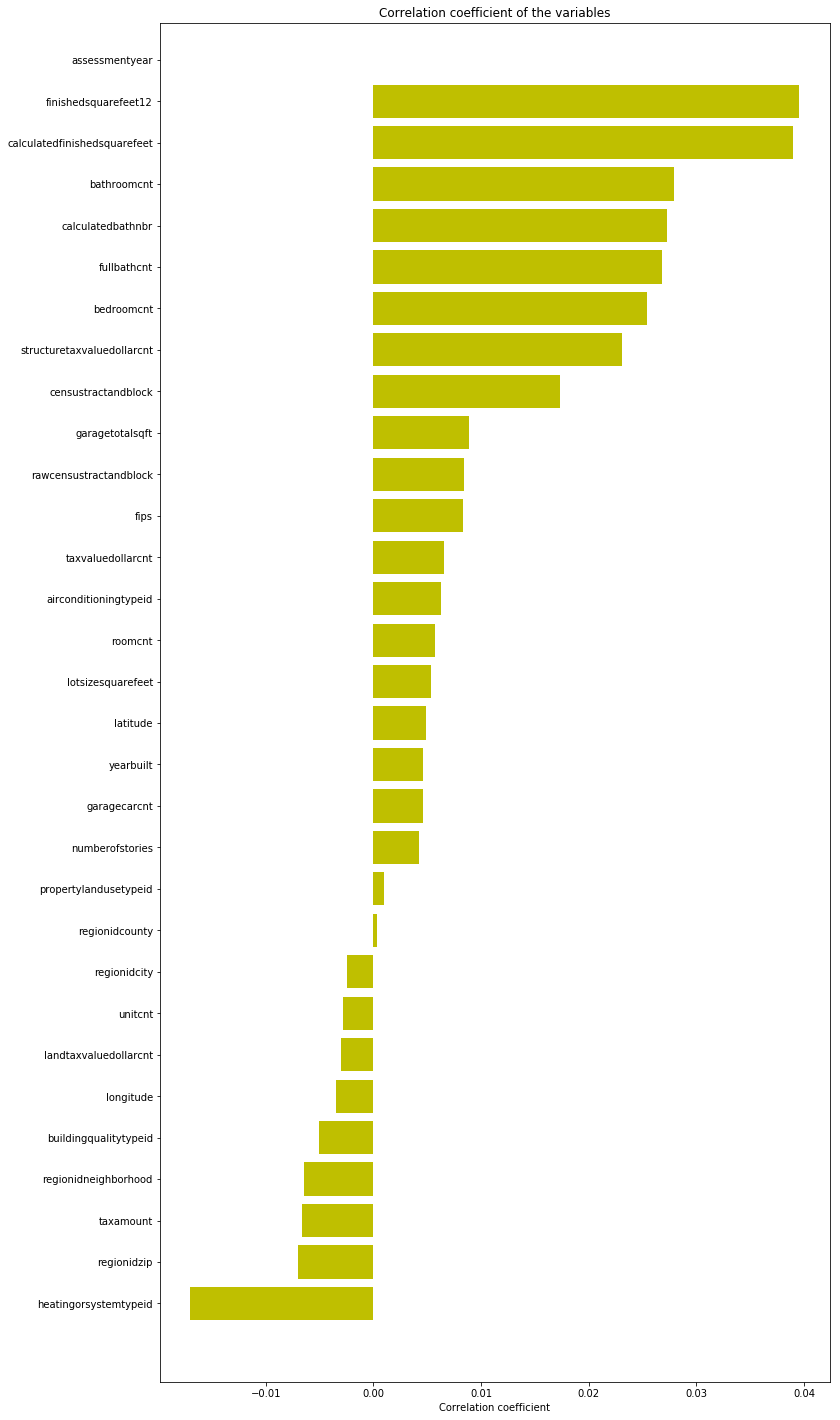

In [23]:
# mean_values = prop_data.mean(axis=0)
# prop_data_new = prop_data.fillna(-1)
train_data = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
train_data = train_data.merge(prop_data, on='parcelid', how='left')
train_data.fillna(-1, inplace=True)

x_cols = [col for col in train_data.columns if col not in ['logerror'] if train_data[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_data[col].values, train_data.logerror.values)[0,1])
corr_data = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_data = corr_data.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.5
fig, ax = plt.subplots(figsize=(12,25))
rects = ax.barh(ind, np.array(corr_data.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_data.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()


We can see that the most correlated variable with the logerror is **finishedsquarefeet12**
Hence, it can be said to be most **important** for the purpose of **Linear Regression**
***

***
Next, we choose the variables which are relatively more correlated with logerror

In [24]:
corr_data_sel = corr_data.loc[(corr_data['corr_values']>0.02) | (corr_data['corr_values'] < -0.01)]
corr_data_sel


,col_labels,corr_values
11,heatingorsystemtypeid,-0.017002
25,structuretaxvaluedollarcnt,0.023141
2,bedroomcnt,0.025467
8,fullbathcnt,0.026777
4,calculatedbathnbr,0.027303
1,bathroomcnt,0.027889
5,calculatedfinishedsquarefeet,0.039011
6,finishedsquarefeet12,0.039555


***
Here we are plotting the pairwise correlation of the variables using a heatmap.
Then we find out the maximum and minimum correlation

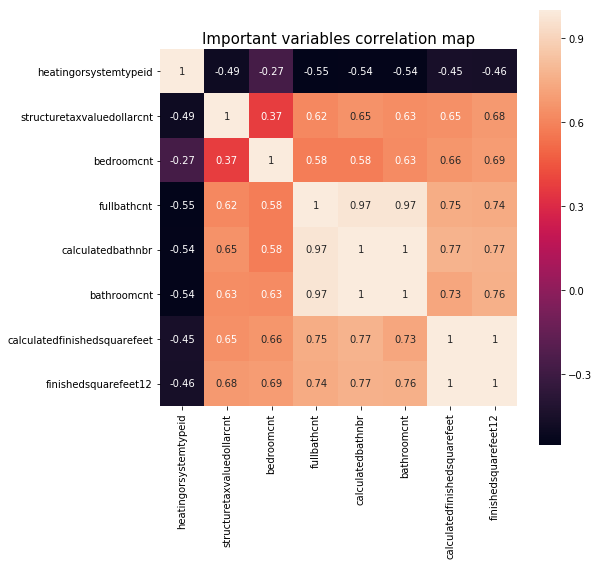

In [25]:
cols_to_use = corr_data_sel.col_labels.tolist()

temp_df = prop_data[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=1., annot=True, square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()


Here the most **positively** correlated variables are:
**finishedsquarefeet12** and **calculatedfinishedsquarefeet**

The most **negatively** correlated variables are:
**fullbathcnt** and **heatingorsystemtypeid**

In [26]:
print "saving clean data to prop_data_clean.csv"
prop_data.to_csv("./prop_data_clean.csv")
prop_data.head()
del prop_data
gc.collect()

saving clean data to prop_data_clean.csv


16497

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jay/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


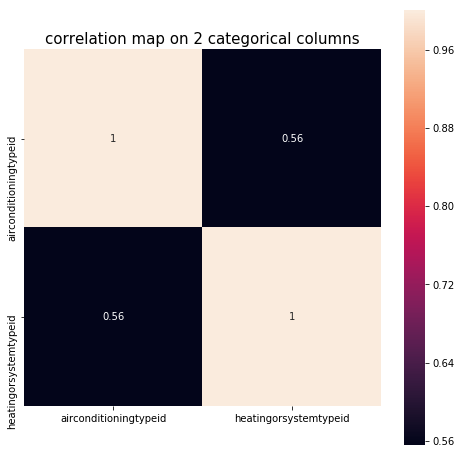

In [27]:
prop_data = pd.read_csv("./prop_data_clean.csv", index_col=0)
prop_data_new = prop_data.fillna(-1)

# Now let us look at the correlation coefficient of each of these variables #
cols_to_use = [col for col in prop_data_new.columns if col in ['airconditioningtypeid', 'heatingorsystemtypeid']]

temp_df = prop_data[cols_to_use]
corrmat = temp_df.corr(method="spearman")
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=1., square=True, annot=True)
plt.title("correlation map on 2 categorical columns", fontsize=15)
plt.show()


These two categorical columns correlate to a decent amount, and hence we can use the less important one among those to fill the missing value of the more important column and then use the latter in the future models
***

In [28]:
prop_data.shape

(2985217, 34)

### Imputing values

Here we employ 3 main strategies to impute data:
1. If the missing data is relatively low, then we use interpolation
2. If the missing data is considerably large, then we take the help of other columns to fill as much data as possible and then fill the remaining data with -1.
3. If the column has large number of missing data but its relation with other columns is not trivially recognizable then we intuitively fill it with, either mean, median or mode.

We start by imputing **airconditioningtypeid**
By observing the data it is found that whenever the <br>
**airconditioningtypeid** = 1.0 the **heatingorsystemtypeid** = 2.0 

In [29]:
#imputing airconditioningtypeid, making some NaN to 1.0 where heatingorsystemtypeid == 2

prop_data.loc[(prop_data["heatingorsystemtypeid"]==2.0) & (pd.isnull(prop_data["airconditioningtypeid"])), "airconditioningtypeid"] = 1.0

prop_data["airconditioningtypeid"].fillna(-1, inplace=True)
print prop_data["airconditioningtypeid"].value_counts()

prop_data[["airconditioningtypeid", "heatingorsystemtypeid"]].head()

-1.0     1723978
 1.0     1192084
 13.0      58457
 5.0        8795
 11.0       1818
 12.0         59
 9.0          19
 3.0           7
Name: airconditioningtypeid, dtype: int64


,airconditioningtypeid,heatingorsystemtypeid
0,-1.0,NaN
1,-1.0,NaN
2,-1.0,NaN
3,-1.0,NaN
4,-1.0,NaN


***
Then by careful analysis of the data we remove some of the columns that either redundant or <br>not so useful
(generally the columns that have correlation of 0 with the logerror are considered not useful)

In [30]:
duplicate_or_not_useful_cols = pd.Series(['calculatedbathnbr', 'assessmentyear', 'fullbathcnt', 
                    'regionidneighborhood', 'propertyzoningdesc', 'censustractandblock'])#,'finishedsquarefeet12'])
prop_data.drop(duplicate_or_not_useful_cols, axis=1, inplace=True)


<br><br>Next we impute some general columns intuitively.

In [31]:
prop_data["buildingqualitytypeid"].fillna(prop_data["buildingqualitytypeid"].mean(), inplace=True)
prop_data["calculatedfinishedsquarefeet"].interpolate(inplace=True)
prop_data["heatingorsystemtypeid"].fillna(-1, inplace=True)
prop_data["lotsizesquarefeet"].fillna(prop_data["lotsizesquarefeet"].median(), inplace=True)
prop_data.drop(["numberofstories"], axis=1, inplace=True)
#removing propertycountylandusecode because it is not in interpretable format
prop_data.drop(["propertycountylandusecode"], axis=1, inplace=True)
prop_data["regionidcity"].interpolate(inplace=True)
prop_data["regionidzip"].interpolate(inplace=True)
prop_data["yearbuilt"].fillna(prop_data["yearbuilt"].mean(), inplace=True)

#impute structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount by interpolation
cols_to_interpolate = ["structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]
for c in cols_to_interpolate:
    prop_data[c].interpolate(inplace=True)


***
Here we are imputing the **garagecarcnt** by using **propertylandusetypeid**<br>
It was observed that most of the residential places have 1 or 2 **garagecarcnt**.
Hence, whenever we encounter **propertylandusetypeid** = 261 or **propertylandusetypeid** = 266 <br>
we use random sampling to fill **garagecarcnt** with 1 or 2
<br>

In [32]:
#imputing garagecarcnt on basis of propertylandusetypeid
#All the residential places have 1 or 2 garagecarcnt, hence using random filling for those values.

prop_data.loc[(prop_data["propertylandusetypeid"]==261) & (pd.isnull(prop_data["garagecarcnt"])), "garagecarcnt"] = np.random.randint(1,3)
prop_data.loc[(prop_data["propertylandusetypeid"]==266) & (pd.isnull(prop_data["garagecarcnt"])), "garagecarcnt"] = np.random.randint(1,3)

prop_data["garagecarcnt"].fillna(-1, inplace=True)

prop_data["garagecarcnt"].value_counts(dropna=False)


 2.0     2114257
 1.0      490979
-1.0      334755
 3.0       19634
 0.0       14005
 4.0        8495
 5.0        1705
 6.0         575
 7.0         266
 8.0         181
 9.0         127
 10.0         78
 11.0         62
 12.0         41
 13.0         16
 14.0         14
 15.0          9
 17.0          4
 16.0          3
 19.0          3
 21.0          2
 20.0          2
 24.0          2
 25.0          1
 18.0          1
Name: garagecarcnt, dtype: int64

***
Here we are imputing the **garagetotalsqft** by using **garagecarcnt**.<br>
It was observed that most of the garage have a standard range of areas in squarefeet which was based on the number of **garagecarcnt**.<br> 
Hence, we can use the **garagecarcnt** to impute the **garagetotalsqft**.<br>
<br>*for eg.* <br>
if **garagecarcnt** == 3 then **garagetotalsqft** will be in range [720, 880)
we use random sampling to fill garagecarcnt with 1 or 2 

In [33]:
#imputing garagetotalsqft using the garagecarcnt

prop_data.loc[(prop_data["garagecarcnt"]==-1) & (pd.isnull(prop_data["garagetotalsqft"]) | (prop_data["garagetotalsqft"] == 0)), "garagetotalsqft"] = -1
prop_data.loc[(prop_data["garagecarcnt"]==1) & (pd.isnull(prop_data["garagetotalsqft"]) | (prop_data["garagetotalsqft"] == 0)), "garagetotalsqft"] = np.random.randint(180, 400)
prop_data.loc[(prop_data["garagecarcnt"]==2) & (pd.isnull(prop_data["garagetotalsqft"]) | (prop_data["garagetotalsqft"] == 0)), "garagetotalsqft"] = np.random.randint(400, 720)
prop_data.loc[(prop_data["garagecarcnt"]==3) & (pd.isnull(prop_data["garagetotalsqft"]) | (prop_data["garagetotalsqft"] == 0)), "garagetotalsqft"] = np.random.randint(720, 880)
prop_data.loc[(prop_data["garagecarcnt"]==4) & (pd.isnull(prop_data["garagetotalsqft"]) | (prop_data["garagetotalsqft"] == 0)), "garagetotalsqft"] = np.random.randint(880, 1200)

#interpolate the remaining missing values
prop_data["garagetotalsqft"].interpolate(inplace=True)

prop_data["garagetotalsqft"].value_counts(dropna=False)


 693.0     1549634
 374.0      400427
-1.0        334755
 400.0       33443
 360.0       29703
 441.0       26753
 462.0       25476
 460.0       23787
 440.0       22717
 420.0       20099
 483.0       17219
 0.0         14011
 480.0       12469
 437.0        9605
 430.0        8882
 456.0        8621
 504.0        8453
 451.0        8112
 484.0        5511
 396.0        5221
 471.0        4822
 380.0        4366
 472.0        4316
 600.0        3924
 450.0        3880
 560.0        3725
 506.0        3660
 630.0        3592
 418.0        3537
 410.0        3516
            ...   
 2174.0          1
 2141.0          1
 2188.0          1
 2192.0          1
 2193.0          1
 2194.0          1
 2196.0          1
 2203.0          1
 2204.0          1
 2150.0          1
 2137.0          1
 2070.0          1
 2095.0          1
 2077.0          1
 2080.0          1
 2084.0          1
 2087.0          1
 2088.0          1
 2090.0          1
 2093.0          1
 2101.0          1
 2129.0     

***
imputing **unitcnt** using **propertylandusetypeid**<br>
**propertylandusetypeid** = 261 [Single Family Residential]<br>
**propertylandusetypeid** = 266 [Condominium]<br>
**propertylandusetypeid** = 269 [Planned Unit Development]<br>
These mostly are related with the **unitcnt** 1<br>
<br>
Following are other implications from the same data: <br>
**propertylandusetypeid** = 246 [Duplex], **unitcnt** = 2<br>
**propertylandusetypeid** = 247 [Triplex], **unitcnt** = 3<br>
**propertylandusetypeid** = 248 [Quadruplex], **unitcnt** = 4<br>


In [34]:
#imputing unitcnt using propertylandusetypeid
            
prop_data.loc[(prop_data["propertylandusetypeid"]==261) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 1
prop_data.loc[(prop_data["propertylandusetypeid"]==266) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 1
prop_data.loc[(prop_data["propertylandusetypeid"]==269) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 1

prop_data.loc[(prop_data["propertylandusetypeid"]==246) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 2
prop_data.loc[(prop_data["propertylandusetypeid"]==247) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 3
prop_data.loc[(prop_data["propertylandusetypeid"]==248) & pd.isnull(prop_data["unitcnt"]), "unitcnt"] = 4

prop_data["unitcnt"].value_counts(dropna=False)


 1.0      2697656
 2.0       116301
NaN         88105
 4.0        40762
 3.0        40313
 5.0          588
 6.0          363
 8.0          178
 7.0          167
 10.0          97
 9.0           91
 12.0          52
 11.0          47
 13.0          35
 16.0          35
 14.0          32
 24.0          28
 20.0          20
 18.0          18
 15.0          17
 32.0          13
 17.0          12
 22.0          12
 27.0          11
 19.0           9
 30.0           9
 23.0           8
 26.0           8
 28.0           8
 21.0           7
           ...   
 131.0          1
 130.0          1
 83.0           1
 61.0           1
 256.0          1
 66.0           1
 68.0           1
 72.0           1
 73.0           1
 74.0           1
 75.0           1
 76.0           1
 77.0           1
 78.0           1
 79.0           1
 85.0           1
 125.0          1
 88.0           1
 91.0           1
 93.0           1
 96.0           1
 98.0           1
 101.0          1
 102.0          1
 112.0    

In [35]:
for column in prop_data:
    print column, "\n",prop_data[column].value_counts(dropna=False), "\n\n\n********"


parcelid 
12584959    1
12755709    1
12751611    1
12753658    1
12747513    1
12749560    1
12776183    1
12778230    1
12772085    1
12774132    1
12767987    1
12770034    1
12763889    1
12729070    1
12722925    1
12724972    1
12718827    1
12720874    1
12714729    1
12743399    1
12745446    1
12757756    1
12761854    1
12741348    1
12759807    1
14016022    1
12820200    1
12427380    1
17066269    1
11446598    1
           ..
10861026    1
10854881    1
10856928    1
10768863    1
10770910    1
10764765    1
10766812    1
10824176    1
10828274    1
10826227    1
10834431    1
12253706    1
12247561    1
12227079    1
12222981    1
12225028    1
12237314    1
12231169    1
12233216    1
10836478    1
10815988    1
10830333    1
10832380    1
10842619    1
10844666    1
10838521    1
10840568    1
10820086    1
10813941    1
12582912    1
Name: parcelid, Length: 2985217, dtype: int64 


********
airconditioningtypeid 
-1.0     1723978
 1.0     1192084
 13.0      58457
 5.0

NaN             11437
-118390000.0     1718
-118438000.0     1585
-118389000.0     1568
-118252000.0     1402
-118432000.0     1371
-118433000.0     1339
-118445000.0     1319
-118435000.0     1290
-118467000.0     1266
-118463000.0     1255
-118436000.0     1193
-118446000.0     1192
-118378000.0     1187
-118263000.0     1169
-118377000.0     1138
-118450000.0     1112
-118188000.0     1107
-118466000.0     1091
-118437000.0     1078
-118186000.0     1063
-118439000.0     1048
-118464000.0     1048
-118374000.0     1031
-118383000.0     1008
-118443000.0     1007
-118130000.0     1003
-118427000.0      988
-118308000.0      966
-118451000.0      965
                ...  
-118380149.0        1
-117806468.0        1
-119076098.0        1
-117808371.0        1
-117835450.0        1
-117646260.0        1
-118386580.0        1
-117618961.0        1
-118597732.0        1
-118247077.0        1
-118405851.0        1
-118528646.0        1
-119034196.0        1
-118170439.0        1
-118770798

366172.0     11456
100000.0      1880
102461.0      1578
104510.0      1513
200000.0      1419
107401.0      1411
101998.0      1388
150000.0      1378
106600.0      1316
90000.0       1289
203996.0      1246
140000.0      1234
120000.0      1178
110000.0      1172
80000.0       1127
95000.0       1083
130000.0      1082
204922.0      1080
75000.0       1071
125000.0      1058
92000.0       1044
94000.0       1044
105000.0      1039
115000.0      1030
84000.0       1020
160000.0      1002
96000.0       1001
91000.0        994
89000.0        990
87000.0        990
             ...  
388429.0         1
388475.0         1
388473.0         1
388468.0         1
388462.0         1
388459.0         1
388456.0         1
388453.0         1
388446.0         1
388444.0         1
388440.0         1
388437.0         1
388435.0         1
388431.0         1
388428.0         1
388386.0         1
388417.0         1
1266685.0        1
388407.0         1
388405.0         1
388403.0         1
388402.0    

In [36]:
prop_data.isnull().sum()

parcelid                             0
airconditioningtypeid                0
bathroomcnt                      11462
bedroomcnt                       11450
buildingqualitytypeid                0
calculatedfinishedsquarefeet         2
finishedsquarefeet12            276033
fips                             11437
garagecarcnt                         0
garagetotalsqft                      0
heatingorsystemtypeid                0
latitude                         11437
longitude                        11437
lotsizesquarefeet                    0
propertylandusetypeid            11437
rawcensustractandblock           11437
regionidcity                         0
regionidcounty                   11437
regionidzip                          0
roomcnt                          11475
unitcnt                          88105
yearbuilt                            0
structuretaxvaluedollarcnt           2
taxvaluedollarcnt                    0
landtaxvaluedollarcnt                0
taxamount                

In [37]:
prop_data.fillna(-1, inplace=True)
prop_data.to_csv("./prop_data_clean_2.csv")

del prop_data
gc.collect()


13424

***
## 5. Creating New features

Here we create some new features based on the preexisting ones.

In [49]:
print "creating new features"
prop_data = pd.read_csv("./prop_data_clean_2.csv", index_col=0)

prop_data['age'] = 2017 - prop_data['yearbuilt']

#proportion of living area
prop_data['N-LivingAreaProp'] = prop_data['calculatedfinishedsquarefeet']/prop_data['lotsizesquarefeet']

#Ratio of the built structure value to land area
prop_data['N-ValueProp'] = prop_data['structuretaxvaluedollarcnt']/prop_data['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
prop_data['N-ValueRatio'] = prop_data['taxvaluedollarcnt']/prop_data['taxamount']


#Average structuretaxvaluedollarcnt by city
group = prop_data.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
prop_data['N-Avg-structuretaxvaluedollarcnt'] = prop_data['regionidcity'].map(group)

#Deviation away from average
prop_data['N-Dev-structuretaxvaluedollarcnt'] = abs((prop_data['structuretaxvaluedollarcnt'] - 
                        prop_data['N-Avg-structuretaxvaluedollarcnt']))/prop_data['N-Avg-structuretaxvaluedollarcnt']

#Number of properties in the zip
zip_count = prop_data['regionidzip'].value_counts().to_dict()
prop_data['N-zip_count'] = prop_data['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = prop_data['regionidcity'].value_counts().to_dict()
prop_data['N-city_count'] = prop_data['regionidcity'].map(city_count)

#Number of properties in the city
region_count = prop_data['regionidcounty'].value_counts().to_dict()
prop_data['N-county_count'] = prop_data['regionidcounty'].map(region_count)

prop_data.to_csv("./prop_data_with_new_features.csv")


creating new features


***
### Plotting the count of real estate and regionidcounty

The maximum real estate is corresponding to the county id 3101

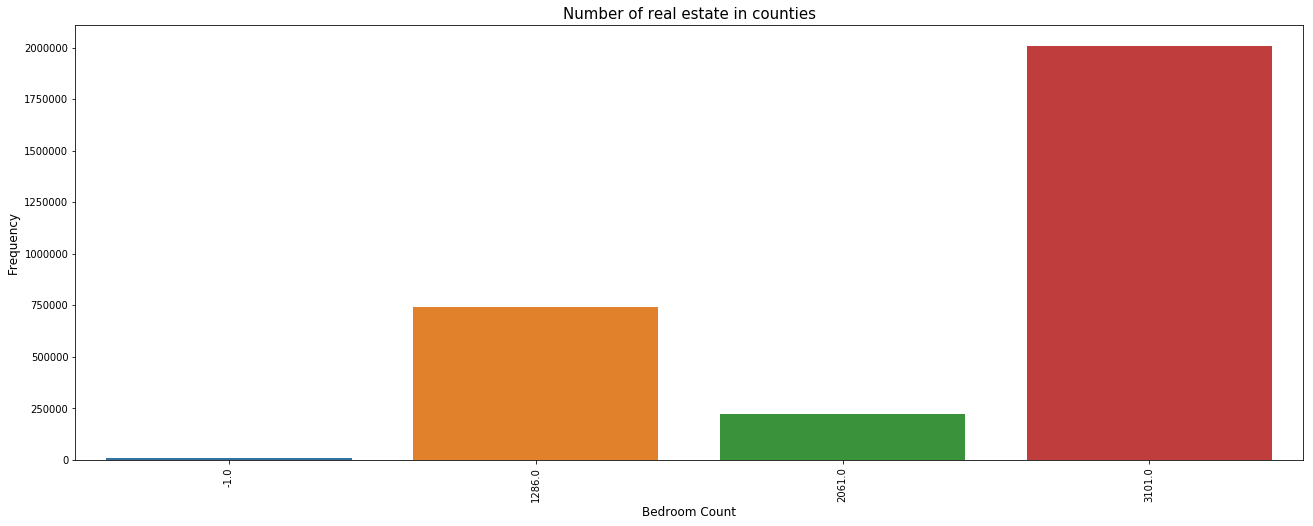

In [50]:
plt.figure(figsize=(22,8))
sb.countplot(x="regionidcounty", data=prop_data)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Number of real estate in counties", fontsize=15)
plt.show()


In [51]:

## Merging the train and prop data
print "Merging the train and prop data" 

train_data = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

train_data = pd.merge(train_data, prop_data, on='parcelid', how='left')
train_data.head()


Merging the train and prop data


,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,taxamount,age,N-LivingAreaProp,N-ValueProp,N-ValueRatio,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt,N-zip_count,N-city_count,N-county_count
0,11016594,0.0276,2016-01-01,1.0,2.0,3.0,4.000000,1684.0,1684.0,6037.0,...,6735.88,58.0,0.223698,0.517042,53.470371,183929.377014,0.332603,14719,673563,2009362
1,14366692,-0.1684,2016-01-01,-1.0,3.5,4.0,5.784787,2263.0,2263.0,6059.0,...,10153.02,3.0,0.621191,1.449185,57.670427,151746.492714,1.283137,17685,22441,741565
2,12098116,-0.0040,2016-01-01,1.0,3.0,2.0,4.000000,2217.0,2217.0,6037.0,...,11484.48,77.0,0.194082,1.070486,10.440699,179879.904106,0.655359,4422,34691,2009362
3,12643413,0.0218,2016-01-02,1.0,2.0,2.0,4.000000,839.0,839.0,6037.0,...,3048.74,30.0,0.011840,2.337968,80.321707,183929.377014,0.067479,7293,673563,2009362
4,14432541,-0.0050,2016-01-02,-1.0,2.5,4.0,5.784787,2283.0,2283.0,6059.0,...,5488.96,36.0,0.380500,0.639957,79.168185,221227.736386,0.233487,9877,9751,741565


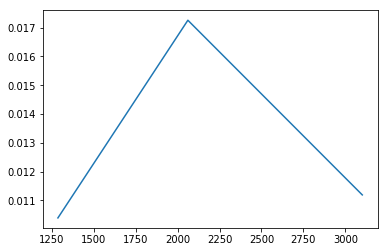

In [52]:
plt.plot(train_data.groupby("regionidcounty")["logerror"].mean())
plt.show()

This shows that the logerror is the most for the county 2061, and it can be seen in the plot before this, that the county 2061 has the least real estate count. Since, there is not much data to compare from, the logerror is more in this area.
***

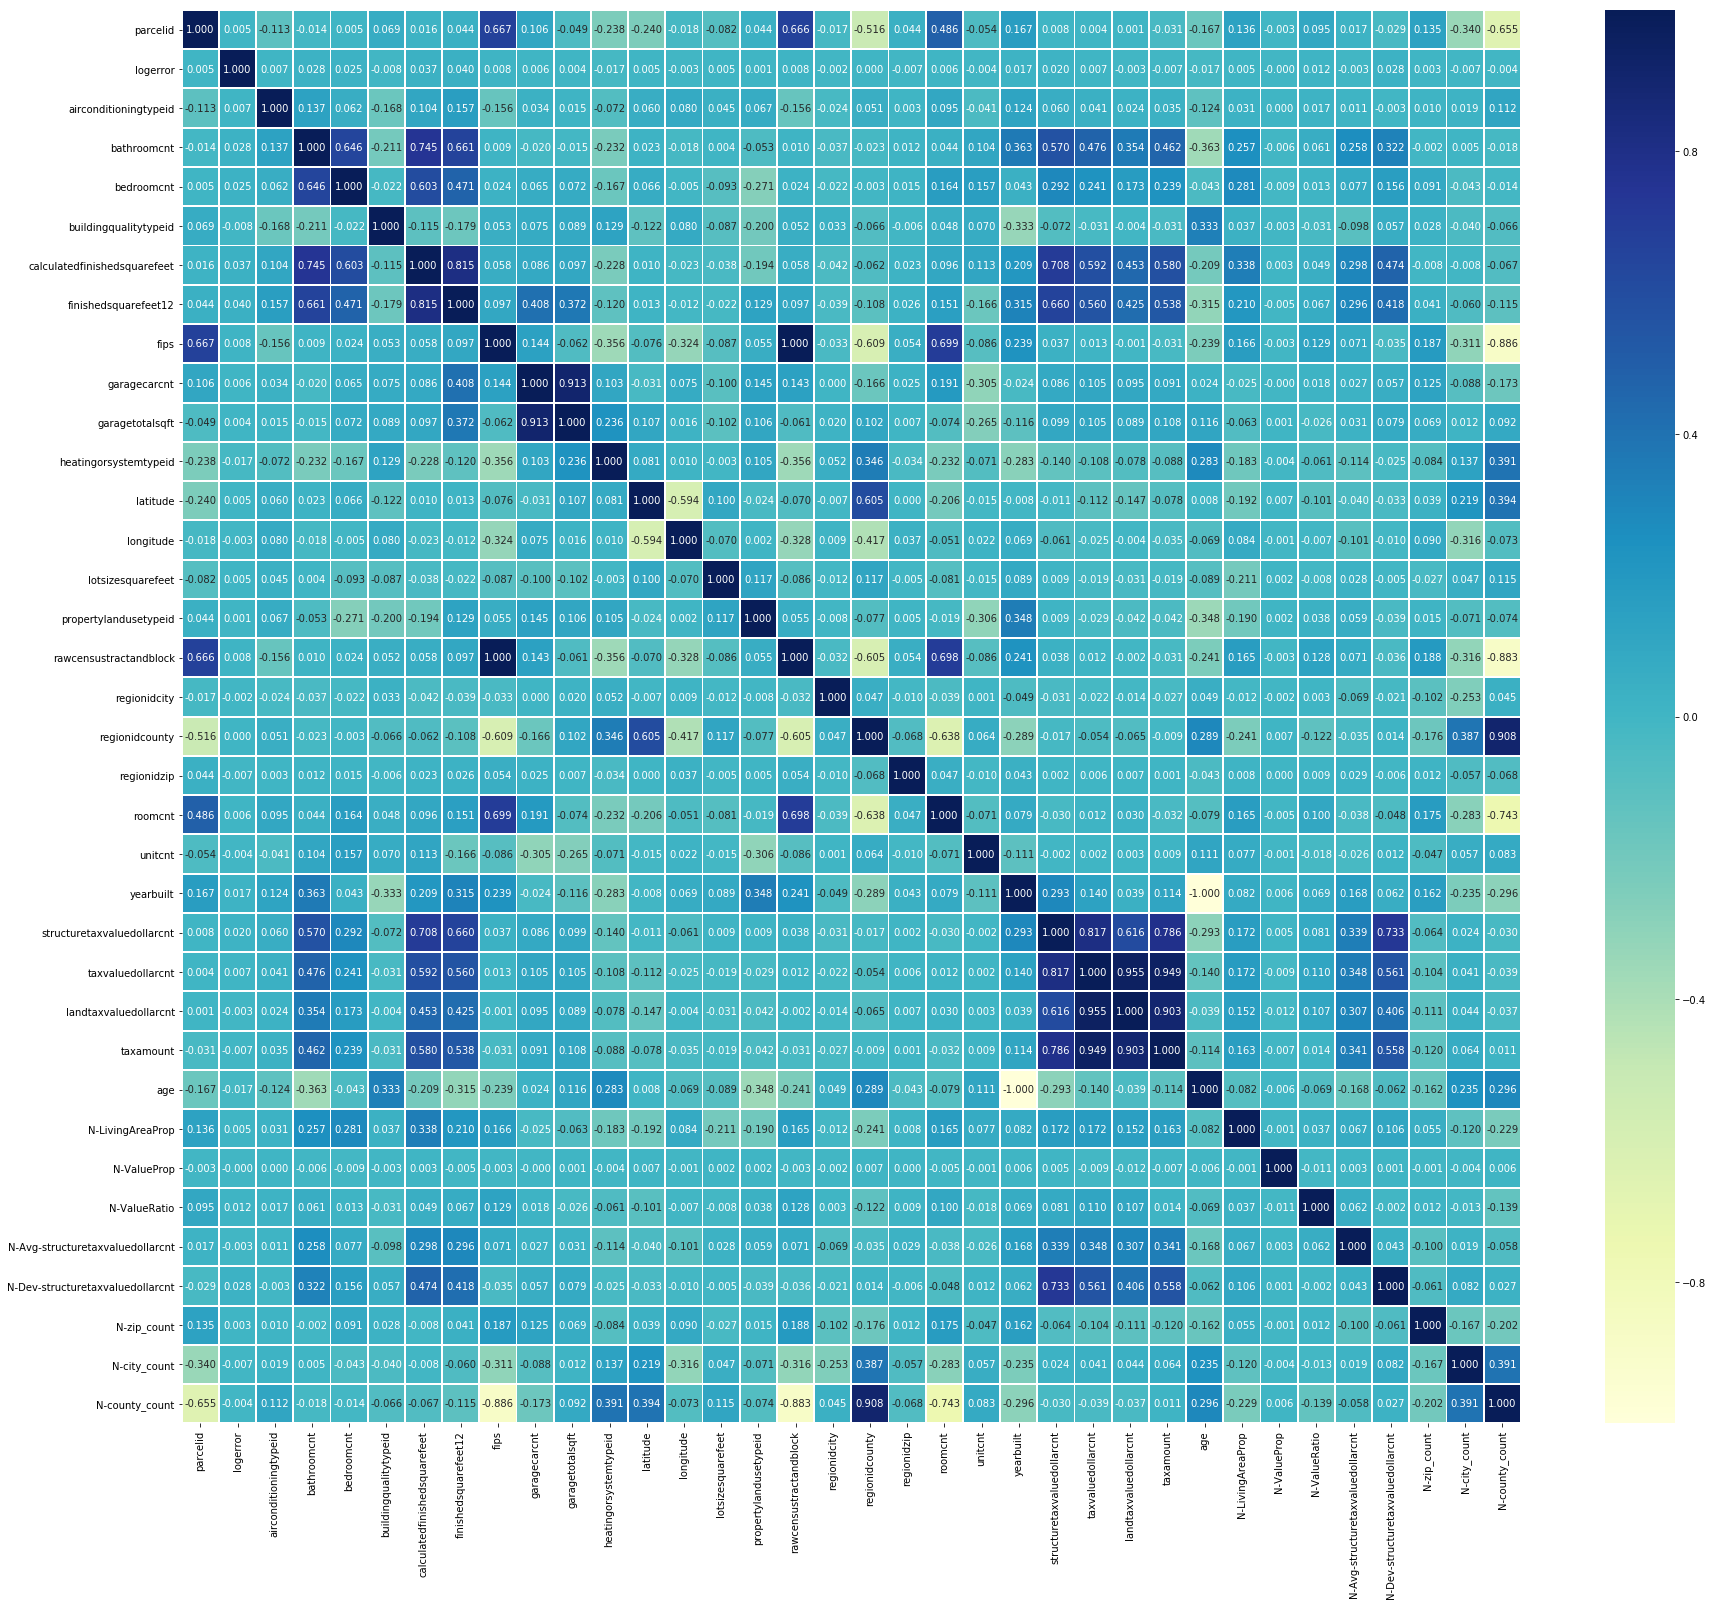

In [53]:
plt.figure(figsize=(30,26))
sb.set_context(font_scale=2.5)
corr_fig = sb.heatmap(train_data.corr("pearson"), cmap="YlGnBu", annot=True, fmt=".3f", linewidths=1.0)
corr_fig = corr_fig.get_figure()
corr_fig.savefig("./correlation_plot_1.png")

### Analysing the above Heatmap

Here we can observe that the tax related variables are highly correlated, which means it is redundant to use all of these for further analysis
Since, 'taxamount' is described as 'The total property tax assessed for that assessment year' it seem like a good option to keep and to discard the other tax variables.

There 3 more pairs of variables that are highly correlated and do not contribute to adding more information.
These pairs are :
1. fips / rawcensustractandblock
2. structuretaxvaluedollarcnt/ landtaxvaluedollarcnt/ taxvaluedollarcnt
3. garagecarcnt / garagetotalsqft

After carefully analysing the data
I decided to drop, rawcensustractandblock, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, garagecarcnt

In [54]:
train_data.drop(["rawcensustractandblock", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "taxvaluedollarcnt", "garagecarcnt"],axis=1, inplace=True)#, "calculatedfinishedsquarefeet"], axis=1, inplace=True)


### Lets plot the correlation again

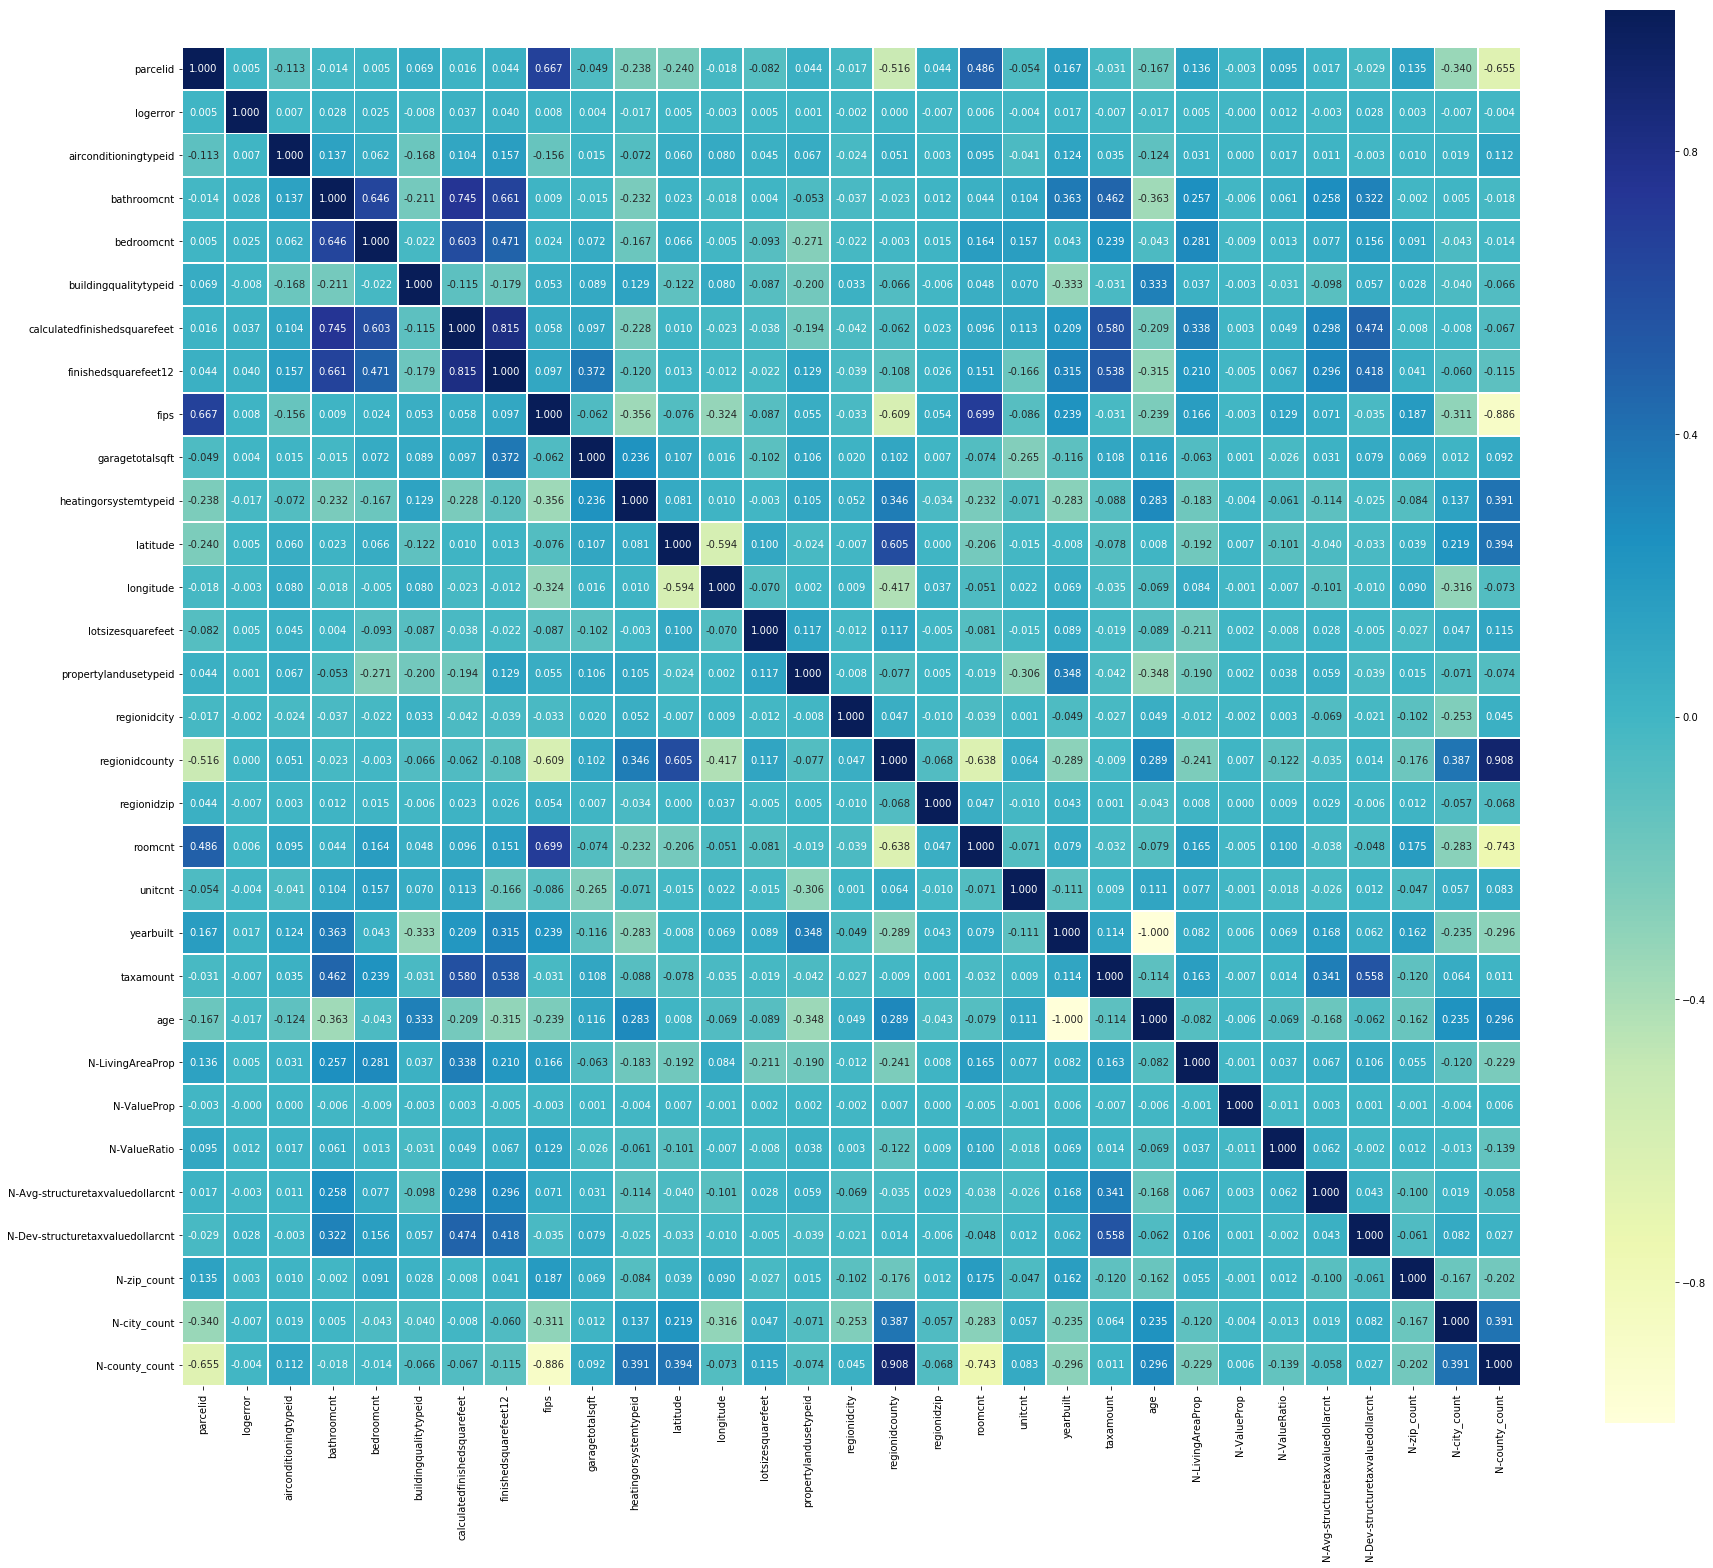

In [55]:
plt.figure(figsize=(30,26))
sb.set_context(font_scale=2.5)
corr_fig = sb.heatmap(train_data.corr("pearson"), cmap="YlGnBu", square=True, annot=True, fmt=".3f", linewidths=1.0)
corr_fig = corr_fig.get_figure()
corr_fig.savefig("./correlation_plot_2.png")

***
## 6. Exploring different models on the final data

We start with two variants of Linear regression,
1. On the better cleaned data
2. Only using the most important feature found in the [Finding the correlation](#finishedsquarefeet_is_imp)

(The commented codes in the following sections was used to test the model on the entire dataset and to make a submission file.)

### Linear Regression on the cleaned data

In [150]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split

sample = pd.read_csv("./sample_submission.csv")
sample['parcelid'] = sample['ParcelId']
test_months = [k for k in sample.columns.values if k not in ["parcelid", "ParcelId"]]
train_data.fillna(train_data.mean(), inplace=True)

cat_cols = []
# cat_cols = ["airconditioningtypeid", "heatingorsystemtypeid", "propertylandusetypeid"]

X_train = train_data.drop(["parcelid", "logerror", "transactiondate"]+cat_cols, axis=1)
y_train = train_data["logerror"].values
# X_test = pd.merge(sample, prop_data, on='parcelid', how='left')
# X_test = X_test[X_train.columns]
# print "X_test shape"
# print X_test.shape

# # Create linear regression object
# regr = linear_model.LinearRegression(normalize=True)
# # Train the model using the training sets
# regr.fit(X_train, y_train)
# # Make predictions using the testing set
# y_pred = regr.predict(X_test)
    
# from datetime import datetime

# for date in test_months:
#     sample[date] = y_pred

# sample["ParcelId"] = sample["parcelid"]
# sample.drop(["parcelid"], axis=1, inplace=True)

# print( "\nWriting results to disk ..." )
# sample.to_csv('LR_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")


X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# print y_pred.shape

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: % f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))



('Coefficients: \n', array([ -1.66293719e-04,   1.51200172e-04,  -2.07988084e-06,
         6.85784172e-06,   3.86004445e-06,   8.37049008e-10,
        -1.80563984e-09,   6.33841048e-09,  -1.90605054e-09,
        -6.03214439e-07,   1.05873584e-04,  -1.04831943e-07,
         1.23903945e-07,  -9.07165027e-08,  -3.69085728e-06,
        -4.81507699e-03,   9.48960583e-07,   2.56667597e-06,
         7.13211422e-03,  -2.25449952e-07]))
Mean squared error:  0.028753
Mean absolute error:  0.069544


### Linear Regression on just one feature **'finishedsquarefeet12'**

In [148]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split

sample = pd.read_csv("./sample_submission.csv")
sample['parcelid'] = sample['ParcelId']
test_months = [k for k in sample.columns.values if k not in ["parcelid", "ParcelId"]]
train_data.fillna(train_data.mean(), inplace=True)

X_train = train_data[["finishedsquarefeet12"]]
y_train = train_data["logerror"].values
X_test = pd.merge(sample, prop_data, on='parcelid', how='left')
X_test = X_test[X_train.columns]
print "X_test shape"
print X_test.shape

# Create linear regression object
regr = linear_model.LinearRegression(normalize=True)
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
    
from datetime import datetime

for date in test_months:
    sample[date] = y_pred

sample["ParcelId"] = sample["parcelid"]
sample.drop(["parcelid"], axis=1, inplace=True)

print( "\nWriting results to disk ..." )
sample.to_csv('LR_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")
# X_train = X_train.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# print y_pred.shape

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: % f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))



X_test shape
(2985217, 1)

Writing results to disk ...
('Coefficients: \n', array([  6.51670615e-06]))
Mean squared error:  0.030650
Mean absolute error:  0.070396


In [66]:
del train_data
del sample
del X_train
del y_train
del X_test
gc.collect()

62

***
### Let's see the feature importance using XGBoost

XGBoost generally finds the feature importance using either of 3 criteria:
1. Gain - is the improvement in accuracy brought by a feature to the branches it is on.
2. Coverage - measures the relative quantity of observations concerned by a feature.
3. Frequency - is a simpler way to measure the Gain. It just counts the number of times a feature is used in all generated trees.

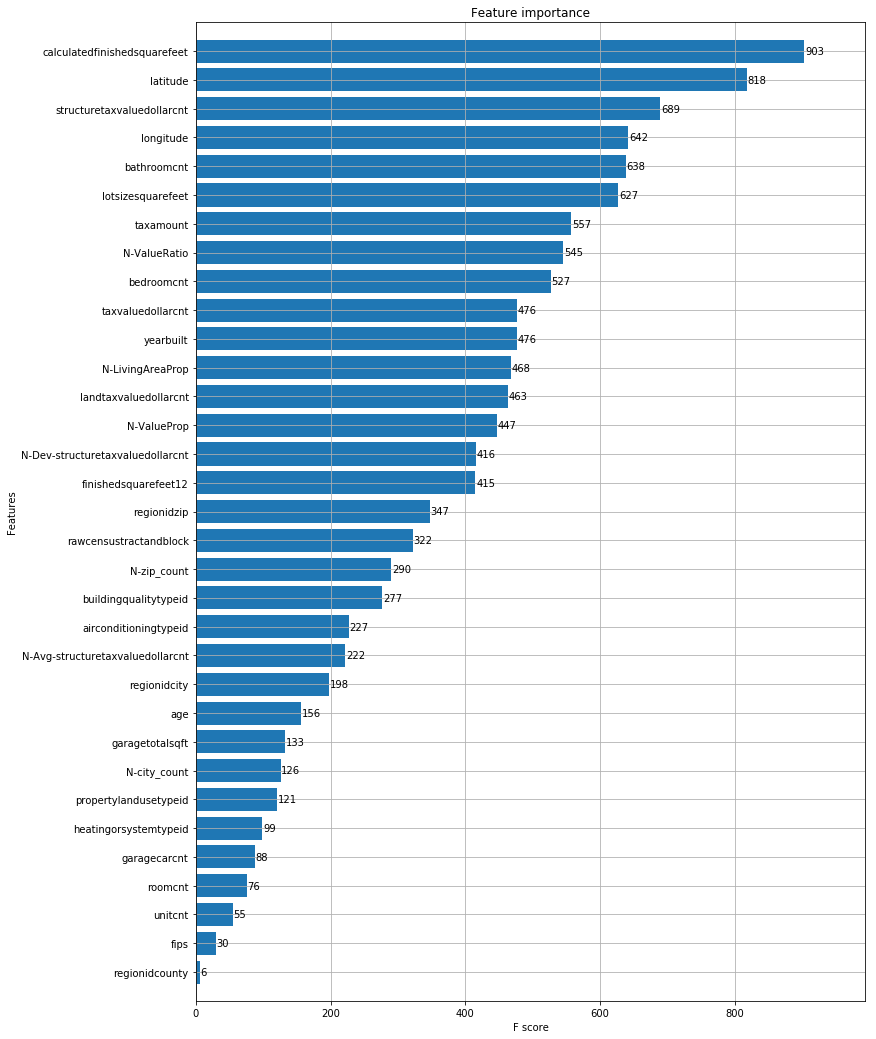

X train cols
['airconditioningtypeid' 'bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid'
 'calculatedfinishedsquarefeet' 'finishedsquarefeet12' 'fips'
 'garagecarcnt' 'garagetotalsqft' 'heatingorsystemtypeid' 'latitude'
 'longitude' 'lotsizesquarefeet' 'propertylandusetypeid'
 'rawcensustractandblock' 'regionidcity' 'regionidcounty' 'regionidzip'
 'roomcnt' 'unitcnt' 'yearbuilt' 'structuretaxvaluedollarcnt'
 'taxvaluedollarcnt' 'landtaxvaluedollarcnt' 'taxamount' 'age'
 'N-LivingAreaProp' 'N-ValueProp' 'N-ValueRatio'
 'N-Avg-structuretaxvaluedollarcnt' 'N-Dev-structuretaxvaluedollarcnt'
 'N-zip_count' 'N-city_count' 'N-county_count']
X_test shape
(18055, 34)
Mean absolute error:  0.068010
Mean squared error: 0.024666


In [152]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

n_features = 20

train_data = pd.read_csv("./train_2016_v2.csv")
sample = pd.read_csv("./sample_submission.csv")
sample['parcelid'] = sample['ParcelId']

train_data = train_data.merge(prop_data, on='parcelid', how='left')

y_train = train_data['logerror'].values
X_train = train_data.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
feat_names = X_train.columns.values
# X_test = pd.merge(sample, prop_data, on='parcelid', how='left')
# X_test = X_test[X_train.columns]

# print "X train cols\n", X_train.columns.values
# print "X_test shape"
# print X_test.shape


xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

thresholds = model.get_fscore()
L = [(k,v) for (k,v) in thresholds.iteritems()]
thresholds = sorted(L, key=lambda x: x[1] , reverse=True)[:n_features]
thresholds = dict(thresholds)

# X_train_new = X_train.drop([k for k in feat_names if k not in thresholds], axis=1)
# # X_train, X_test, y_train, y_test = train_test_split( X_train, train_y, test_size=0.2, random_state=42)

# dtrain = xgb.DMatrix(X_train_new, y_train, feature_names=X_train_new.columns.values)
# X_test = xgb.DMatrix(X_test[X_train_new.columns])
# model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)
    
# y_pred = model.predict(X_test)

# for date in test_months:
#     sample[date] = y_pred

# sample["ParcelId"] = sample["parcelid"]
# sample.drop(["parcelid"], axis=1, inplace=True)

# print( "\nWriting results to disk ..." )
# sample.to_csv('XGB_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()
                

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

print "X train cols\n", X_train.columns.values
print "X_test shape"
print X_test.shape

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

thresholds = model.get_fscore()
L = [(k,v) for (k,v) in thresholds.iteritems()]
thresholds = sorted(L, key=lambda x: x[1] , reverse=True)[:n_features]
thresholds = dict(thresholds)
    
X_test = xgb.DMatrix(X_test[X_train.columns])

y_pred = model.predict(X_test)


print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))


In [153]:
not_to_drop = ['parcelid', 'logerror', 'transactiondate']
X_train = train_data.drop([k for k in train_data.columns.values if k not in thresholds.keys() + not_to_drop], axis=1)
print X_train.columns.values
X_train.to_csv("./important_features.csv", index=False)

del train_data
del sample
del X_train
# del X_train_new
del y_train
del X_test
gc.collect()

['parcelid' 'logerror' 'transactiondate' 'bathroomcnt' 'bedroomcnt'
 'buildingqualitytypeid' 'calculatedfinishedsquarefeet'
 'finishedsquarefeet12' 'latitude' 'longitude' 'lotsizesquarefeet'
 'rawcensustractandblock' 'regionidzip' 'yearbuilt'
 'structuretaxvaluedollarcnt' 'taxvaluedollarcnt' 'landtaxvaluedollarcnt'
 'taxamount' 'N-LivingAreaProp' 'N-ValueProp' 'N-ValueRatio'
 'N-Dev-structuretaxvaluedollarcnt' 'N-zip_count']


29907

### Ridge Regression

This is a Linear regression model with a regularisation parameter. Regularisation is imposing penalty loss function of the model if it becomes too complex thereby preventing it from overfitting. Here the model uses L2-norm as a regularisation term.

In [155]:
train_data = pd.read_csv("./important_features.csv")

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# cat_cols = ["airconditioningtypeid", "heatingorsystemtypeid", "propertylandusetypeid"]
y_train = train_data["logerror"].values
X_train = train_data.drop(["parcelid", "logerror", "transactiondate"], axis=1)

# X_test = pd.merge(sample, prop_data, on='parcelid', how='left')
# X_test = X_test[X_train.columns]
# print "X_test shape"
# print X_test.shape

# reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], normalize=True, gcv_mode='auto')
# reg.fit( X_train, y_train)       
# y_pred = reg.predict(X_test)
    
# from datetime import datetime

# for date in test_months:
#     sample[date] = y_pred

# sample["ParcelId"] = sample["parcelid"]
# sample.drop(["parcelid"], axis=1, inplace=True)

# print( "\nWriting results to disk ..." )
# sample.to_csv('LR_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")


# print "X train cols\n", X_train.columns.values

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)#, random_state=42)

# sc = StandardScaler(with_mean=True, with_std=True)
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

pca = PCA(n_components=20, svd_solver='auto')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# scorer = make_scorer(mean_sbsolute_error, greater_is_better=False)
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], normalize=True, gcv_mode='auto')
reg.fit( X_train, y_train)       
y_pred = reg.predict(X_test)


print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))

print reg.alpha_
print reg.coef_
print reg.intercept_

Mean absolute error:  0.068738
Mean squared error: 0.027424
0.1
[  3.24732240e-12   1.56523950e-09  -1.74160438e-09  -2.82598140e-08
  -8.38506869e-09   4.66445501e-09  -1.65345819e-07   6.45948996e-10
  -5.05089550e-07  -3.04074498e-06  -6.53874375e-06  -6.02936993e-07
   9.72135830e-08  -8.09363887e-06  -1.71392977e-05  -2.40371744e-04
  -2.23981458e-05   8.18607785e-03   1.00792042e-03  -3.95564882e-03]
0.0109532608696


### Lasso Regression

LASSO (Least Absolute Shrinkage Selector Operator)
This is similar to Ridge regression, with the only difference in the regularisation term. <br>
Lasso uses L1 regularization technique (will be discussed later in this article)

In [156]:
X_train = train_data.drop(["parcelid", "logerror", "transactiondate"], axis=1)
y_train = train_data["logerror"].values

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

# sc = StandardScaler(with_mean=True, with_std=True)
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

pca = PCA(n_components=20, svd_solver='auto')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# print "X train cols\n", X_train.columns.values

# scorer = make_scorer(mean_sbsolute_error, greater_is_better=False)
reg = linear_model.LassoCV(normalize=True, precompute='auto', n_jobs=-1, selection='random')
reg.fit( X_train, y_train)       

y_pred = reg.predict(X_test)

print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))


print reg.alpha_
print reg.coef_
print reg.intercept_


Mean absolute error:  0.067646
Mean squared error: 0.023411
1.22339618806e-06
[  8.28614251e-10   2.64799167e-09  -0.00000000e+00  -2.63859160e-08
  -3.61591970e-09   3.65259141e-09  -1.81376809e-07  -0.00000000e+00
  -2.72768133e-07  -2.71436885e-06  -6.03511029e-06   1.52711524e-06
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   1.13557837e-04
   6.38830326e-04  -3.61391830e-03   6.84838054e-03  -3.52243852e-03]
0.0115338008862


### Multi-Layer Perceptron

Described in detail at the end of the notebook.

In [62]:
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sample = pd.read_csv('./sample_submission.csv')


X_train = train_data.drop(["parcelid", "logerror", "transactiondate"], axis=1)
y_train = train_data["logerror"].values

print "X train cols\n", X_train.columns.values

# print('Creating df_test...')
# sample['parcelid'] = sample['ParcelId']
# test_months = [k for k in sample.columns.values if k not in ["parcelid"]]

# print("Merging Sample with property data...")
# X_test = sample.merge(prop_data, on='parcelid', how='left')
# X_test = X_test[X_train.columns.values]

# test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
# test_columns = ['201610','201611','201612','201710','201711','201712']

# pca = PCA(n_components=1, svd_solver='auto')
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print pca.explained_variance_
# reg = MLPRegressor(hidden_layer_sizes=(150, 50, 25), tol=1e-6, max_iter=10000, warm_start=True, verbose=True)#, early_stopping=True, validation_fraction=0.3)

# for i in range(100):
#     reg.fit(X_train, y_train)

# y_pred = reg.predict(X_test)



# from datetime import datetime

# for date in test_columns:
#     sample[date] = y_pred

# sample["ParcelId"] = sample["parcelid"]
# sample.drop(["parcelid"], axis=1, inplace=True)

# print( "\nWriting results to disk ..." )
# sample.to_csv('MLP_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

sc = StandardScaler(with_mean=True, with_std=True)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components=1, svd_solver='auto')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print pca.explained_variance_

# reg = MLPRegressor(hidden_layer_sizes=(50, 50), solver='sgd', learning_rate='adaptive', tol=1e-6, max_iter=10000, warm_start=True, verbose=True, early_stopping=True, validation_fraction=0.3)
reg = MLPRegressor(hidden_layer_sizes=(150, 50, 25), tol=1e-6, max_iter=10000, warm_start=True, verbose=True)#, early_stopping=True, validation_fraction=0.3)

for i in range(100):
    reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))



X train cols
['bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid'
 'calculatedfinishedsquarefeet' 'finishedsquarefeet12' 'latitude'
 'longitude' 'lotsizesquarefeet' 'rawcensustractandblock' 'regionidzip'
 'yearbuilt' 'structuretaxvaluedollarcnt' 'taxvaluedollarcnt'
 'landtaxvaluedollarcnt' 'taxamount' 'N-LivingAreaProp' 'N-ValueProp'
 'N-ValueRatio' 'N-Dev-structuretaxvaluedollarcnt' 'N-zip_count']
Creating df_test...
Merging Sample with property data...
[  4.86506473e+11]
Iteration 1, loss = 1583672.68247004
Iteration 2, loss = 2820.47174114
Iteration 3, loss = 61382.19059202
Iteration 4, loss = 650251.19151719
Iteration 5, loss = 18814.83463934
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 6, loss = 153632.38593725
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 7, loss = 93068.36758061
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
It

Iteration 73, loss = 0.01297737
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 74, loss = 0.01297550
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 75, loss = 0.01297441
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 76, loss = 0.01297689
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 77, loss = 0.01297541
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 78, loss = 0.01297637
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 79, loss = 0.01297597
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 80, loss = 0.01297550
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 81, lo

Iteration 35, loss = 0.01367395
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 36, loss = 0.01354378
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 37, loss = 0.01354417
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 38, loss = 0.01354252
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 39, loss = 0.01354428
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 40, loss = 0.01353997
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 41, loss = 0.01354007
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 42, loss = 0.01353992
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 43, lo

Iteration 104, loss = 0.01353533
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 105, loss = 0.01353806
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 106, loss = 0.01354040
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 107, loss = 0.01354000
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 108, loss = 0.01353934
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 109, loss = 0.01354393
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 110, loss = 0.01353905
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteration 111, loss = 0.01354516
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Stopping.
Iteratio

### K-Nearest Neighbors

In [157]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2)

neigh = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
neigh.fit(X_train, y_train) 

y_pred = neigh.predict(X_test)

print("Mean absolute error: % f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %f" % mean_squared_error(y_test, y_pred))
# from datetime import datetime

# for date in test_months:
#     sample[date] = nn_pred

# sample["ParcelId"] = sample["parcelid"]
# sample.drop(["parcelid"], axis=1, inplace=True)


# print( "\nWriting results to disk ..." )
# sample.to_csv('k_NN_sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

# print( "\nFinished ...")

Mean absolute error:  0.084448
Mean squared error: 0.029983


***
## Description of MLP

Multi-layer Perceptron is my favourite model. It is because, it can model almost all type data of varying complexity.
<br><br>
- This model is based on the way a Human brain works.<br>
- It is basically an arrangement of small units called Neurons.<br>
- These neurons are connected with other neurons in the next layer.<br> 
- The neurons are activated on the basis of the input to the activation function.<br>

<img src="http://scikit-learn.org/stable/_images/multilayerperceptron_network.png" alt="Alt text that describes the graphic" title="Title text" />

Each Layer has assigned weights to each incoming connection to the neurons in the layer and also each layer has a bias term. <br><br>

The Image represents a basic neural network.

The leftmost layer, known as the input layer, consists of a set of neurons \{x_i | x_1, x_2, ..., x_m\} representing the input features. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation w_1\*x_1 + w_2\*x_2 + ... + w_m*x_m, followed by a non-linear activation function like the hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.
